### Imports

In [1]:
import rawpy
import colour
import matplotlib as mpl
import numpy as np
from matplotlib.pyplot import imshow
from scipy import signal
from PIL import Image

mpl.rcParams["figure.figsize"] = 5, 10

### Variables

## Raw Converter

In [2]:
IMAGE_NAME = "DSC_1967"
INPUT_PATH = "../samples/" + IMAGE_NAME + ".nef"
NOISE_SAMPLE_PATH = "../samples/kodak-portra.npy"

EXP = 2

In [3]:
sample = np.load(NOISE_SAMPLE_PATH)

with rawpy.imread(INPUT_PATH) as raw:
    rgb = raw.postprocess(
        output_color=rawpy.ColorSpace(1), half_size=True,
        use_camera_wb=True,  # user_wb=(1,1,1,1),
        output_bps=16, no_auto_bright=True, no_auto_scale=False,
        gamma=(1, 1), chromatic_aberration=(1, 1),
    )

    wb = raw.camera_whitebalance

rgb = rgb.astype(np.float32)
print(wb)

[1.734375, 1.0, 1.3125, 1.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


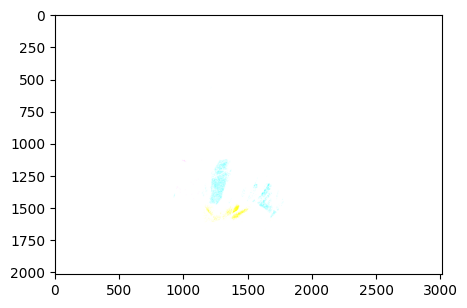

In [4]:
imshow(rgb)

In [5]:
rgb_autoscale = (rgb * (50000 / np.average(rgb))) + 794

Hyperbolic decay formula
$$\begin{cases}
\dfrac{(x - 1)^2 (kx + k + 1)}{(k + 1)(kx + 1)}, &x < 1\\
0, &x \ge 1
\end{cases}$$
where $k>0$ is the decay coefficient.

In [6]:
def blur(size: int = 10, k: int = 50):
    x = np.fabs(np.linspace(-size, size, size * 2 + 1) / size)
    kernel_1d = (
            (x - 1) ** 2 * ((x * k) + k + 1)
            /
            (k + 1) * (k * x + 1)
    )

    kernel_2d = np.outer(kernel_1d.T, kernel_1d.T)
    summa = np.sum(kernel_2d)
    kernel_2d = kernel_2d / summa
    return kernel_2d

In [7]:
rgb_blur = np.dstack((
    signal.convolve2d(rgb_autoscale[:, :, 0], blur(12, 25), 'same'),
    signal.convolve2d(rgb_autoscale[:, :, 1], blur(5, 25), 'same'),
    signal.convolve2d(rgb_autoscale[:, :, 2], blur(3, 25), 'same')
))

In [8]:
def grain(rgb1, amplify, sample):
    grain = sample * amplify
    print(np.average(sample))
    grained = np.power(np.sqrt(np.sqrt(rgb1)) + grain, 4)
    return grained

In [9]:
rgblog = np.log10(rgb_blur)
rgblog_1_0 = (
        (rgblog - np.min(rgblog))
        /
        (np.max(rgblog) - np.min(rgblog))
)

In [10]:
np.save("../../out/" + IMAGE_NAME + ".npy", rgblog_1_0)

## Do Film

In [11]:
img = np.load("../../out/DSC_1967.npy")

In [12]:
END_A_PLUS = 2.5
END_A_MINUS = 1
END_B_PLUS = 1
END_B_MINUS = 4

SUT = .6
CONT = 4
WEIGHT = 254

In [13]:
ex_comp_auto = img - np.average(img) - 0.07
print(np.average(ex_comp_auto))

-0.07


In [14]:
img_contrast = (
        1
        /
        (1 + (np.power(10 ** CONT, -ex_comp_auto)))
)

img_contrast = colour.RGB_to_XYZ(
    img_contrast,
    'sRGB',
    chromatic_adaptation_transform=None,
    illuminant=None)

to_ProLab = colour.XYZ_to_ProLab(img_contrast)

In [15]:
to_ProLab[:, :, 1][np.where(to_ProLab[:, :, 1] < 0)] = ((2 / (1 + (
    np.power((16 ** END_A_MINUS), -(((to_ProLab[:, :, 1][np.where(to_ProLab[:, :, 1] < 0)])) * SUT) / 100)))) - 1) * (
                                                               100 / END_A_MINUS)  # a+ ибо обратились к 2 каналу где этот канал больше нуля
to_ProLab[:, :, 1][np.where(to_ProLab[:, :, 1] >= 0)] = ((2 / (1 + (
    np.power((16 ** END_B_PLUS), -((to_ProLab[:, :, 1][np.where(to_ProLab[:, :, 1] >= 0)]) * SUT) / 100)))) - 1) * (
                                                                100 / END_A_PLUS)
to_ProLab[:, :, 2][np.where(to_ProLab[:, :, 2] < 0)] = ((2 / (1 + (
    np.power((16 ** END_B_MINUS), -((to_ProLab[:, :, 2][np.where(to_ProLab[:, :, 2] < 0)]) * SUT) / 100)))) - 1) * (
                                                               100 / END_B_MINUS)
to_ProLab[:, :, 2][np.where(to_ProLab[:, :, 2] >= 0)] = ((2 / (1 + (
    np.power((16 ** END_B_PLUS), -((to_ProLab[:, :, 2][np.where(to_ProLab[:, :, 2] >= 0)]) * SUT) / 100)))) - 1) * (
                                                                100 / END_B_PLUS)  # ((2/1+16**yx)-1)*100/y
# to_ProLab[:,:,2]=((2/(1+(np.power((250**sut),-to_ProLab[:,:,2]/100))))-1)*45
print(np.max(to_ProLab[:, :, 2]))

26.9519936093


In [16]:
to_XYZ = colour.ProLab_to_XYZ(to_ProLab)
to_rgb = colour.XYZ_to_RGB(
    to_XYZ, 
    'sRGB', 
    chromatic_adaptation_transform=None, 
    illuminant=None)

to_sRgb = colour.RGB_to_RGB(to_XYZ, 'Adobe RGB (1998)', 'sRGB')

In [17]:
to_out = np.around(to_rgb * WEIGHT)

print(np.min(to_out))
print(np.max(to_out))

to_out[np.where(to_out <= 0)] = 0
to_out[np.where(to_out >= 255)] = 255

out = to_out.astype(np.uint8)

pill = Image.fromarray(out)
pill.show()

1.0
236.0
